In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import my_types, homography, warp, rectification, utils

In [2]:
DATA = Path("data")

# Pick Correspondences

In [3]:
im1 = io.imread("data/doll1.jpg")
im2 = io.imread("data/doll2.jpg")
im3 = io.imread("data/doll3.jpg")

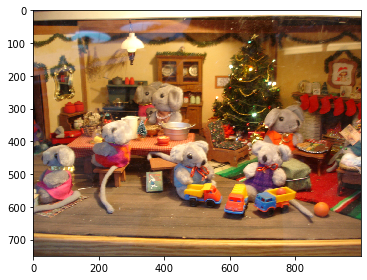

In [4]:
io.imshow(im2)

In [7]:
PICK_NEW = False
im1_name = DATA / "doll1.jpg"
im2_name = DATA / "doll2.jpg"

if PICK_NEW:
    %matplotlib tk
    # im3_name = DATA / "doll3.jpg"
    im1_pts = utils.pick_points(im1_name, 8)
    im2_pts = utils.pick_points(im2_name, 8)
    # im3_pts = utils.pick_points(im3_name, 8)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)
    # utils.save_points(im3_pts, im3_name)
else:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
    # im3_pts = utils.load_points(im3_name)

In [8]:
im1_pts

array([[710.53896104, 651.69155844],
       [712.56818182, 511.67532468],
       [720.68506494, 398.03896104],
       [864.75974026, 300.63636364],
       [803.88311688, 288.46103896],
       [970.27922078, 499.5       ],
       [588.78571429, 576.61038961],
       [548.2012987 , 462.97402597]])

In [9]:
im2_pts

array([[235.7012987 , 615.16558442],
       [247.87662338, 475.14935065],
       [243.81818182, 365.57142857],
       [393.98051948, 264.11038961],
       [347.30844156, 260.05194805],
       [479.20779221, 442.68181818],
       [124.09415584, 554.28896104],
       [ 69.30519481, 444.71103896]])

In [13]:
# find homographic transformation matrix
T = homography.homo_matrix(im1_pts, im2_pts)

TypeError: append() takes exactly one argument (2 given)